<a href="https://colab.research.google.com/github/fatima-bukhari5/liveness_detection_colab/blob/main/Hyper_Parameter_Tuning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library Imports


In [1]:
# Reference section to call important lib.

# mathemathical & data manupulation
import numpy as np          # numpy for mathemathical operations
import pandas as pd         # to manage data in two dimension structures

# O/S, command line, serialization, deserialization, iterations
import argparse             # command line arguments management.
import pickle               # pickle for object serialization/de-serialization
import os                   # to interact with operating system
import itertools            # to enhance iteration over object, i.e. for loop

# image processing
import cv2                  # opencv for image pre-processing
from imutils import paths   # another convienance for image processing like opencv

# For Data visualization & charts
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Reference to Scikit Learn for data pre-processing & post training
# performance evaluation. 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Reference to keras with tensorflow engine for model training.
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INIT_LR = 0.0001  # a variable for learning rate parameter while training
BS = 10           # batch size
EPOCHS = 16       # a variable for number of epochs parameter while training model

In [4]:
# location for training, validation & testing dataset 
train_path = '/content/drive/MyDrive/real_and_fake/train'
valid_path = '/content/drive/MyDrive/real_and_fake/valid'
test_path = '/content/drive/MyDrive/real_and_fake/test'

In [5]:
def read_image_data(X,Y, height, width):
    '''
    The following function is to convert the data into numpy array through
    `data_processing` function and resize it according vgg16 input size 
    of 224 by 224.
    
    Requirement:  Convert input images to heightxwidth for VGG16
    Usage:        Pre-Processing.
    Functionality:
                  1. load images one by one from folder, resize & attach lable.
                  2. Convert image to numpy array & return array with lable. 
    Parameters:
                  X => df['Image paths'] (dataframe column of image paths)
                  Y => df['Labels'] (dataframe column of image labels)

    Returns:      `image` in the form of numpy array & labels as encoded.
    '''
    # to do: variables & parmeters naming convention.
    # declaration Section
    data =[]                                      # An array to hold images.
    labels = Y                                    # A variable to hold label from parameter.
    # execution section    
    # to do: exception handling
    for path in X:                                # for each image in a given folder.
        image = cv2.imread(path)                  # reading image from given path.
        image = cv2.resize(image,(height,width))       # resizing image as of input requirement.
        data.append(image)                        # add image to declared array structure.
    data, labels = data_processing(data, labels)  # Calling & passing parameters to data_processing function.
    # to do: use python log api for console message, if any. print is childish.
    print('[INFO] Converting Data into Image form and encoding labels')
    # return section
    return data, labels

In [6]:
def data_organization(img_path):
    '''
    This function is to organize the data in the form of data frames to have clear understanding 
    and readability of data w.r.t to its labels

    Parameters: 
    img_path = folder path of images base folder as string

    Returns: dataframe with organized image paths and their labels
    '''
    print("Getting labels for images...")
    data = []
    labels = []
    list_image_path = []
    folders_list = os.listdir(img_path)
    
    # loop over all folders at a time. i.e real and fake
    for folder in folders_list:
        
        # extract the class label from the filename to add into the df
    
        folder_path = os.path.join(img_path,folder)
        images_list = os.listdir(folder_path)
        for image_name in images_list:
            label = folder
            imagePath = os.path.join(folder_path,image_name)
            labels.append(label)
            list_image_path.append(imagePath)
            
    image_path_label = {'image_path': list_image_path,'labels':labels}
    df_image_path_label = pd.DataFrame(image_path_label)
    
    print("DataFrame Complete....")
    return df_image_path_label

In [7]:
def data_processing(data,labels):
    '''
    Data processing to convert images data to numpy along with label encoding
    
    Parameters:
    data -> list of images data
    labels -> list of labels
    
    returns:
    data, labels as numpy array of image data and encoded labels
    '''
    data = np.array(data, dtype="float")
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    
    return data, labels

In [8]:
def get_predictions(model, df_testing, height, width):
    '''
    Getting predictions w.r.t to the trained model as passed and the training data
    
    Parameters:
    model: trained model
    df_testing: data for testing in the form of dataframe
    
    Returns:
    
    Predictions as 0 or 1 and true_labels after data processing
    '''
    
    # getting test data in numpy 
    test_data, true_labels = read_image_data(df_testing['image_path'], df_testing['labels'], height, width) 
    
    # gettin predictions against the model
    print('[INFO] Getting Predictions')
    predictions = model.predict(test_data, steps=1, verbose=0)
    predictions_rounded = np.round(predictions)
    
    return predictions_rounded, true_labels

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def model_performance(predictions, true_labels):
    '''
    The model displays a confusion matrix using a previously built confusion matrix function taken from sklearn.
    
    Parameters:
    predictions: previous predictions
    true_labels: array of actual labels to be compared
    
    Result: dislay confusion matrix
    '''
    print('[INFO] Getting Confusion Matrix')
    cm = confusion_matrix(true_labels[:,0], predictions[:,0])
    

    cm_plot_labels = ['real','fake']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    

In [11]:
def build_model(num_classes, height, width, model_name):
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)
    # initializer = tf.keras.initializers.GlorotNormal(seed = 7)
    tf.random.set_seed(42)
    inputs = layers.Input(shape=(height, width, 3,))
    x = img_augmentation(inputs)

    # importing the requires model
    if model_name == "effnet_v2l":
      model = keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, input_tensor=x, weights="imagenet")
    elif model_name == "effnet_b2":
      model = keras.applications.efficientnet.EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
    elif model_name == "nas_net":
      model = keras.applications.nasnet.NASNetLarge(include_top=False, input_tensor=x, weights="imagenet")
    elif model_name == "inc_resnet_v2":
      model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    # x = layers.Dense(128, kernel_initializer=initializer, activation='relu')
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name=model_name)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
def train_model_get_predictions():
  df_training = data_organization(train_path)
  df_validation = data_organization(valid_path)
  df_testing = data_organization(test_path)

  all_models = ['effnet_v2l', 'effnet_b2', 'nas_net', 'inc_resnet_v2']

  train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224, 224)
  val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], 224, 224)

  all_predictions = {}
  for model_name in all_models:
    model = build_model(num_classes = 2, height=224, width=224, model_name=model_name)
    print("[INFO] Training model ", model_name)
    hist = model.fit(x=train_data, y=train_labels, validation_data=(val_data, val_labels), verbose=2, batch_size = BS,  
          validation_steps=5, steps_per_epoch=len(train_data) / BS, epochs=20)

    # get predictions
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing, height = 224, width = 224)
    all_predictions[model_name] = {"predictions": predictions,
                                   "true_labels": true_labels, 
                                   "hist": hist}
  return all_predictions


In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
all_results = train_model_get_predictions()

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
473186304/473176280 [==============================] - 8s 0us/step
[INFO] Training model  effnet_v2l
Epoch 1/20
30/30 - 43s - loss: 1.4518 - accuracy: 0.6567 - val_loss: 0.0531 - val_accuracy: 1.0000 - 43s/epoch - 1s/step
Epoch 2/20
30/30 - 6s - loss: 1.0087 - accuracy: 0.7833 - val_loss: 0.0164 - val_accuracy: 1.0000 - 6s/epoch - 184ms/step
Epoch 3/20
30/30 - 5s - loss: 1.1689 - accuracy: 0.7900 - val_loss: 0.0546 - val_accuracy: 0.9800 - 5s/epoch - 165ms/step
Epoch 4/20
30/30 - 5s - loss: 0.9630 - accuracy: 0.8300 - val_loss: 0.1332 - val_accuracy: 0.9200 - 5s/epoch - 166ms/step
Epoch 5/20
30/30 - 6s - loss: 0.9450 - accuracy: 0.8300 - val_loss: 0.0112 - val_accuracy: 1.0000 - 6s/epoch - 185ms/step
Epoch 6/20
30/30

Effnet_v2l
[INFO] Getting Confusion Matrix
Confusion matrix, without normalization
[[91  9]
 [ 1 28]]


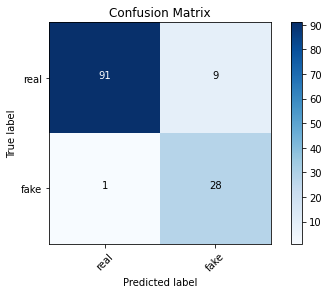

In [15]:
print("Effnet_v2l")
model_performance(predictions=all_results['effnet_v2l']['predictions'], true_labels = all_results['effnet_v2l']['true_labels'])

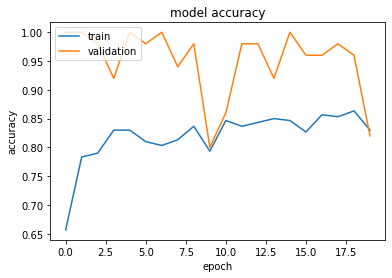

In [16]:
plot_hist(all_results['effnet_v2l']['hist'])

effnet_b7
[INFO] Getting Confusion Matrix
Confusion matrix, without normalization
[[91  9]
 [ 2 27]]


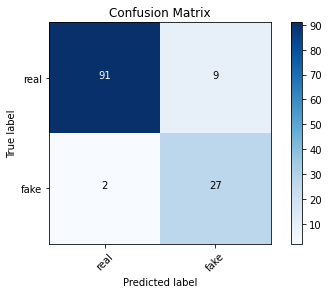

In [18]:
print("effnet_b7")
model_performance(predictions=all_results['effnet_b2']['predictions'], true_labels = all_results['effnet_b2']['true_labels'])

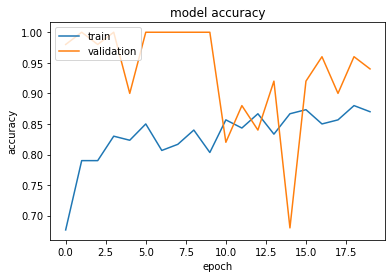

In [19]:
plot_hist(all_results['effnet_b2']['hist'])

nas_net
[INFO] Getting Confusion Matrix
Confusion matrix, without normalization
[[65 35]
 [ 1 28]]


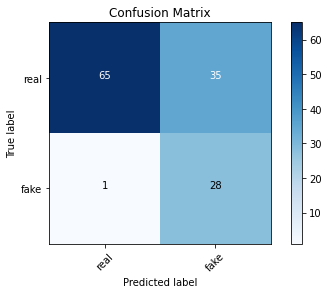

In [20]:
print("nas_net")
model_performance(predictions=all_results['nas_net']['predictions'], true_labels = all_results['nas_net']['true_labels'])

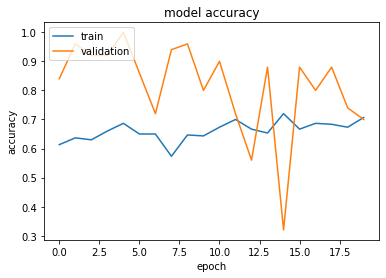

In [21]:
plot_hist(all_results['nas_net']['hist'])

inc_resnet_v2
[INFO] Getting Confusion Matrix
Confusion matrix, without normalization
[[69 31]
 [14 15]]


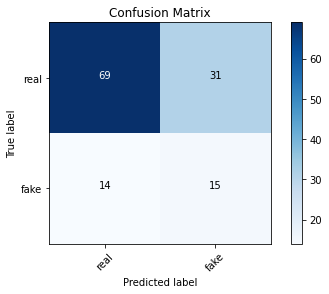

In [22]:
print("inc_resnet_v2")
model_performance(predictions=all_results['inc_resnet_v2']['predictions'], true_labels = all_results['inc_resnet_v2']['true_labels'])

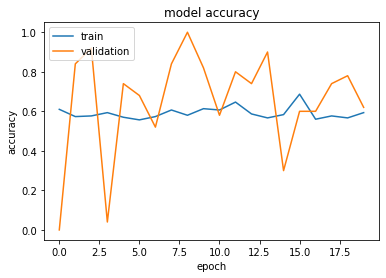

In [23]:
plot_hist(all_results['inc_resnet_v2']['hist'])

Model Tuning for NAS NET

In [14]:
def build_model_tune(num_classes = 2, height = 224, width =224, model_name = "nas_net", lr = 0.001):
  img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)
  initializer = tf.keras.initializers.GlorotNormal(seed = 7)
  inputs = layers.Input(shape=(height, width, 3,))
  x = img_augmentation(inputs)

     # importing the requires model
  if model_name == "effnet_v2l":
    model = keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, input_tensor=x, weights="imagenet")
  elif model_name == "effnet_b2":
    model = keras.applications.efficientnet.EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
  elif model_name == "nas_net":
    model = keras.applications.nasnet.NASNetLarge(include_top=False, input_tensor=x, weights="imagenet")
  elif model_name == "inc_resnet_v2":
    model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
  model.trainable = False

    # Rebuild top
  x = layers.Dense(3, kernel_initializer=initializer, activation='relu')
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="softmax", name="pred")(x)
  # Compile
  model = tf.keras.Model(inputs, outputs, name=model_name)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
  return model


In [42]:
# getting data
df_training = data_organization(train_path)
df_validation = data_organization(valid_path)
df_testing = data_organization(test_path)

train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224, 224)
val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], 224, 224)

# getting the model
model = KerasClassifier(build_fn = build_model_tune, verbose = 2)

learnRate = [1e-2, 1e-3]
batchSize = [4, 8, 16]
epochs = [10, 20]
grid = dict(
            batch_size = batchSize,
            epochs = epochs)
print(grid)

print("[INFO] performing grid search...")
searcher = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring="accuracy", verbose = 2)
searchResults = searcher.fit(train_data, train_labels, verbose = 2)


Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
{'batch_size': [4, 8, 16], 'epochs': [10, 20]}
[INFO] performing grid search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File 

Epoch 1/10
75/75 - 24s - loss: 0.9643 - accuracy: 0.5767 - 24s/epoch - 320ms/step
Epoch 2/10
75/75 - 6s - loss: 0.9396 - accuracy: 0.6200 - 6s/epoch - 75ms/step
Epoch 3/10
75/75 - 6s - loss: 0.9220 - accuracy: 0.6067 - 6s/epoch - 76ms/step
Epoch 4/10
75/75 - 6s - loss: 0.9802 - accuracy: 0.6333 - 6s/epoch - 76ms/step
Epoch 5/10
75/75 - 6s - loss: 0.8689 - accuracy: 0.6100 - 6s/epoch - 76ms/step
Epoch 6/10
75/75 - 6s - loss: 0.8543 - accuracy: 0.6967 - 6s/epoch - 75ms/step
Epoch 7/10
75/75 - 6s - loss: 0.9797 - accuracy: 0.5800 - 6s/epoch - 74ms/step
Epoch 8/10
75/75 - 6s - loss: 0.9356 - accuracy: 0.6300 - 6s/epoch - 74ms/step
Epoch 9/10
75/75 - 6s - loss: 0.8899 - accuracy: 0.6833 - 6s/epoch - 74ms/step
Epoch 10/10
75/75 - 6s - loss: 0.9885 - accuracy: 0.6400 - 6s/epoch - 73ms/step


In [43]:
print("Best: %f using %s" % (searchResults.best_score_, searchResults.best_params_))

Best: nan using {'batch_size': 4, 'epochs': 10}


In [44]:
print("[INFO] performing random search...")
searcher_rs = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3, param_distributions=grid, scoring="accuracy")
searchResults_rs = searcher.fit(train_data, train_labels)
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore, bestParams))


[INFO] performing random search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.buil

Epoch 1/10
75/75 - 21s - loss: 1.0377 - accuracy: 0.6133 - 21s/epoch - 280ms/step
Epoch 2/10
75/75 - 6s - loss: 0.9084 - accuracy: 0.5933 - 6s/epoch - 74ms/step
Epoch 3/10
75/75 - 6s - loss: 0.9465 - accuracy: 0.6300 - 6s/epoch - 74ms/step
Epoch 4/10
75/75 - 6s - loss: 0.9554 - accuracy: 0.6500 - 6s/epoch - 75ms/step
Epoch 5/10
75/75 - 6s - loss: 0.9267 - accuracy: 0.6367 - 6s/epoch - 76ms/step
Epoch 6/10
75/75 - 6s - loss: 0.8220 - accuracy: 0.6633 - 6s/epoch - 75ms/step
Epoch 7/10
75/75 - 6s - loss: 0.8306 - accuracy: 0.6633 - 6s/epoch - 75ms/step
Epoch 8/10
75/75 - 6s - loss: 0.9631 - accuracy: 0.6533 - 6s/epoch - 74ms/step
Epoch 9/10
75/75 - 6s - loss: 0.8544 - accuracy: 0.6600 - 6s/epoch - 74ms/step
Epoch 10/10
75/75 - 6s - loss: 0.8376 - accuracy: 0.6767 - 6s/epoch - 74ms/step
[INFO] best score is nan using {'batch_size': 4, 'epochs': 10}


In [45]:
# df_training = data_organization(train_path)
# df_validation = data_organization(valid_path)
# df_testing = data_organization(test_path)

# train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224, 224)
# val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], 224, 224)

# getting the model
model = build_model_tune()
hist_nas_net = model.fit(x=train_data, y=train_labels, validation_data=(val_data, val_labels), verbose=2, batch_size = 4,  
          validation_steps=5, steps_per_epoch=len(train_data) / BS, epochs=10)

    # get predictions
predictions_nas_net, true_labels_nas_net = get_predictions(model = model, df_testing=df_testing, height = 224, width = 224)

Epoch 1/10
30/30 - 23s - loss: 1.2904 - accuracy: 0.5917 - val_loss: 0.7854 - val_accuracy: 0.5000 - 23s/epoch - 769ms/step
Epoch 2/10
30/30 - 3s - loss: 0.8970 - accuracy: 0.6167 - val_loss: 0.2931 - val_accuracy: 0.8500 - 3s/epoch - 87ms/step
Epoch 3/10
30/30 - 3s - loss: 1.1213 - accuracy: 0.5917 - val_loss: 0.1845 - val_accuracy: 1.0000 - 3s/epoch - 96ms/step
Epoch 4/10
30/30 - 3s - loss: 1.0058 - accuracy: 0.5667 - val_loss: 0.3090 - val_accuracy: 0.8000 - 3s/epoch - 88ms/step
Epoch 5/10
30/30 - 3s - loss: 0.8832 - accuracy: 0.5917 - val_loss: 0.2629 - val_accuracy: 0.9000 - 3s/epoch - 97ms/step
Epoch 6/10
30/30 - 3s - loss: 0.8649 - accuracy: 0.5917 - val_loss: 0.7615 - val_accuracy: 0.6500 - 3s/epoch - 88ms/step
Epoch 7/10
30/30 - 3s - loss: 0.7914 - accuracy: 0.6667 - val_loss: 0.2745 - val_accuracy: 0.9000 - 3s/epoch - 88ms/step
Epoch 8/10
30/30 - 3s - loss: 0.7440 - accuracy: 0.6917 - val_loss: 0.5514 - val_accuracy: 0.7000 - 3s/epoch - 89ms/step
Epoch 9/10
30/30 - 3s - loss:

In [14]:
!pip install keras_tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 14.7 MB/s 


In [15]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''

  img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)
  initializer = tf.keras.initializers.GlorotNormal(seed = 7)
  inputs = layers.Input(shape=(224, 224, 3,))
  x = img_augmentation(inputs)

  # Initialize the Sequential API and start stacking the layers
  model = keras.applications.nasnet.NASNetLarge(include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  x = layers.Dense(units=hp_units, activation='relu', name='dense_1')

  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dense(2, activation="softmax", name="pred")(x)
  model = tf.keras.Model(inputs, outputs, name="Tuned_Model")

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])
  return model

In [16]:
tuned_model = model_builder(kt.HyperParameters())

343621632/343610240 [==============================] - 6s 0us/step


In [17]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    max_trials=5,
    executions_per_trial=3,
    objective="accuracy",
    directory="/content"
)

In [18]:
df_training = data_organization(train_path)
df_validation = data_organization(valid_path)
df_testing = data_organization(test_path)

train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224, 224)
val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], 224, 224)

tuner.search(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

Trial 5 Complete [00h 05m 25s]
accuracy: 0.7577777703603109

Best accuracy So Far: 0.7633333206176758
Total elapsed time: 00h 25m 14s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in /content/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 288
learning_rate: 0.001
Score: 0.7633333206176758
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
Score: 0.7577777703603109
Trial summary
Hyperparameters:
units: 384
learning_rate: 0.01
Score: 0.7400000095367432
Trial summary
Hyperparameters:
units: 480
learning_rate: 0.01
Score: 0.7277777989705404
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.0001
Score: 0.7066666682561239


In [20]:
best_model = tuner.get_best_models()[0]

In [26]:
best_model.summary()

Model: "Tuned_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 96  2592        ['img_augmentation[0][0]']       
                                )                                                                 
                                                                                        

In [30]:
df_testing = data_organization(test_path)
predictions, true_labels = get_predictions(model = best_model, df_testing=df_testing, height = 224, width = 224)

Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Getting Predictions


nas_net
[INFO] Getting Confusion Matrix
Confusion matrix, without normalization
[[94  6]
 [ 9 20]]


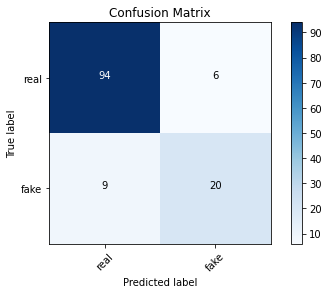

In [31]:
print("nas_net")
model_performance(predictions=predictions, true_labels = true_labels)